# Combustion Chemistry in Isobaric Reactor: Generatign Training Database in the Original State Space

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


# from scipy.integrate import solve_ivp
# import pyDOE    
# from PCAfold         import PCA          as PCAA

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Variables

In [2]:
OutputDir    = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_150Cases_UncParams/')
ParamsDir    = os.path.join(WORKSPACE_PATH, 'Modify_CANTERA/Run_1/')
FigDir       = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet/')

n_samples    = 150

tStratch     = 1.
SOLVER       = 'BDF'

valid_perc   = 20.

FixedMinVal  = 1.e-14


ColorVec     = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

## Reading Data

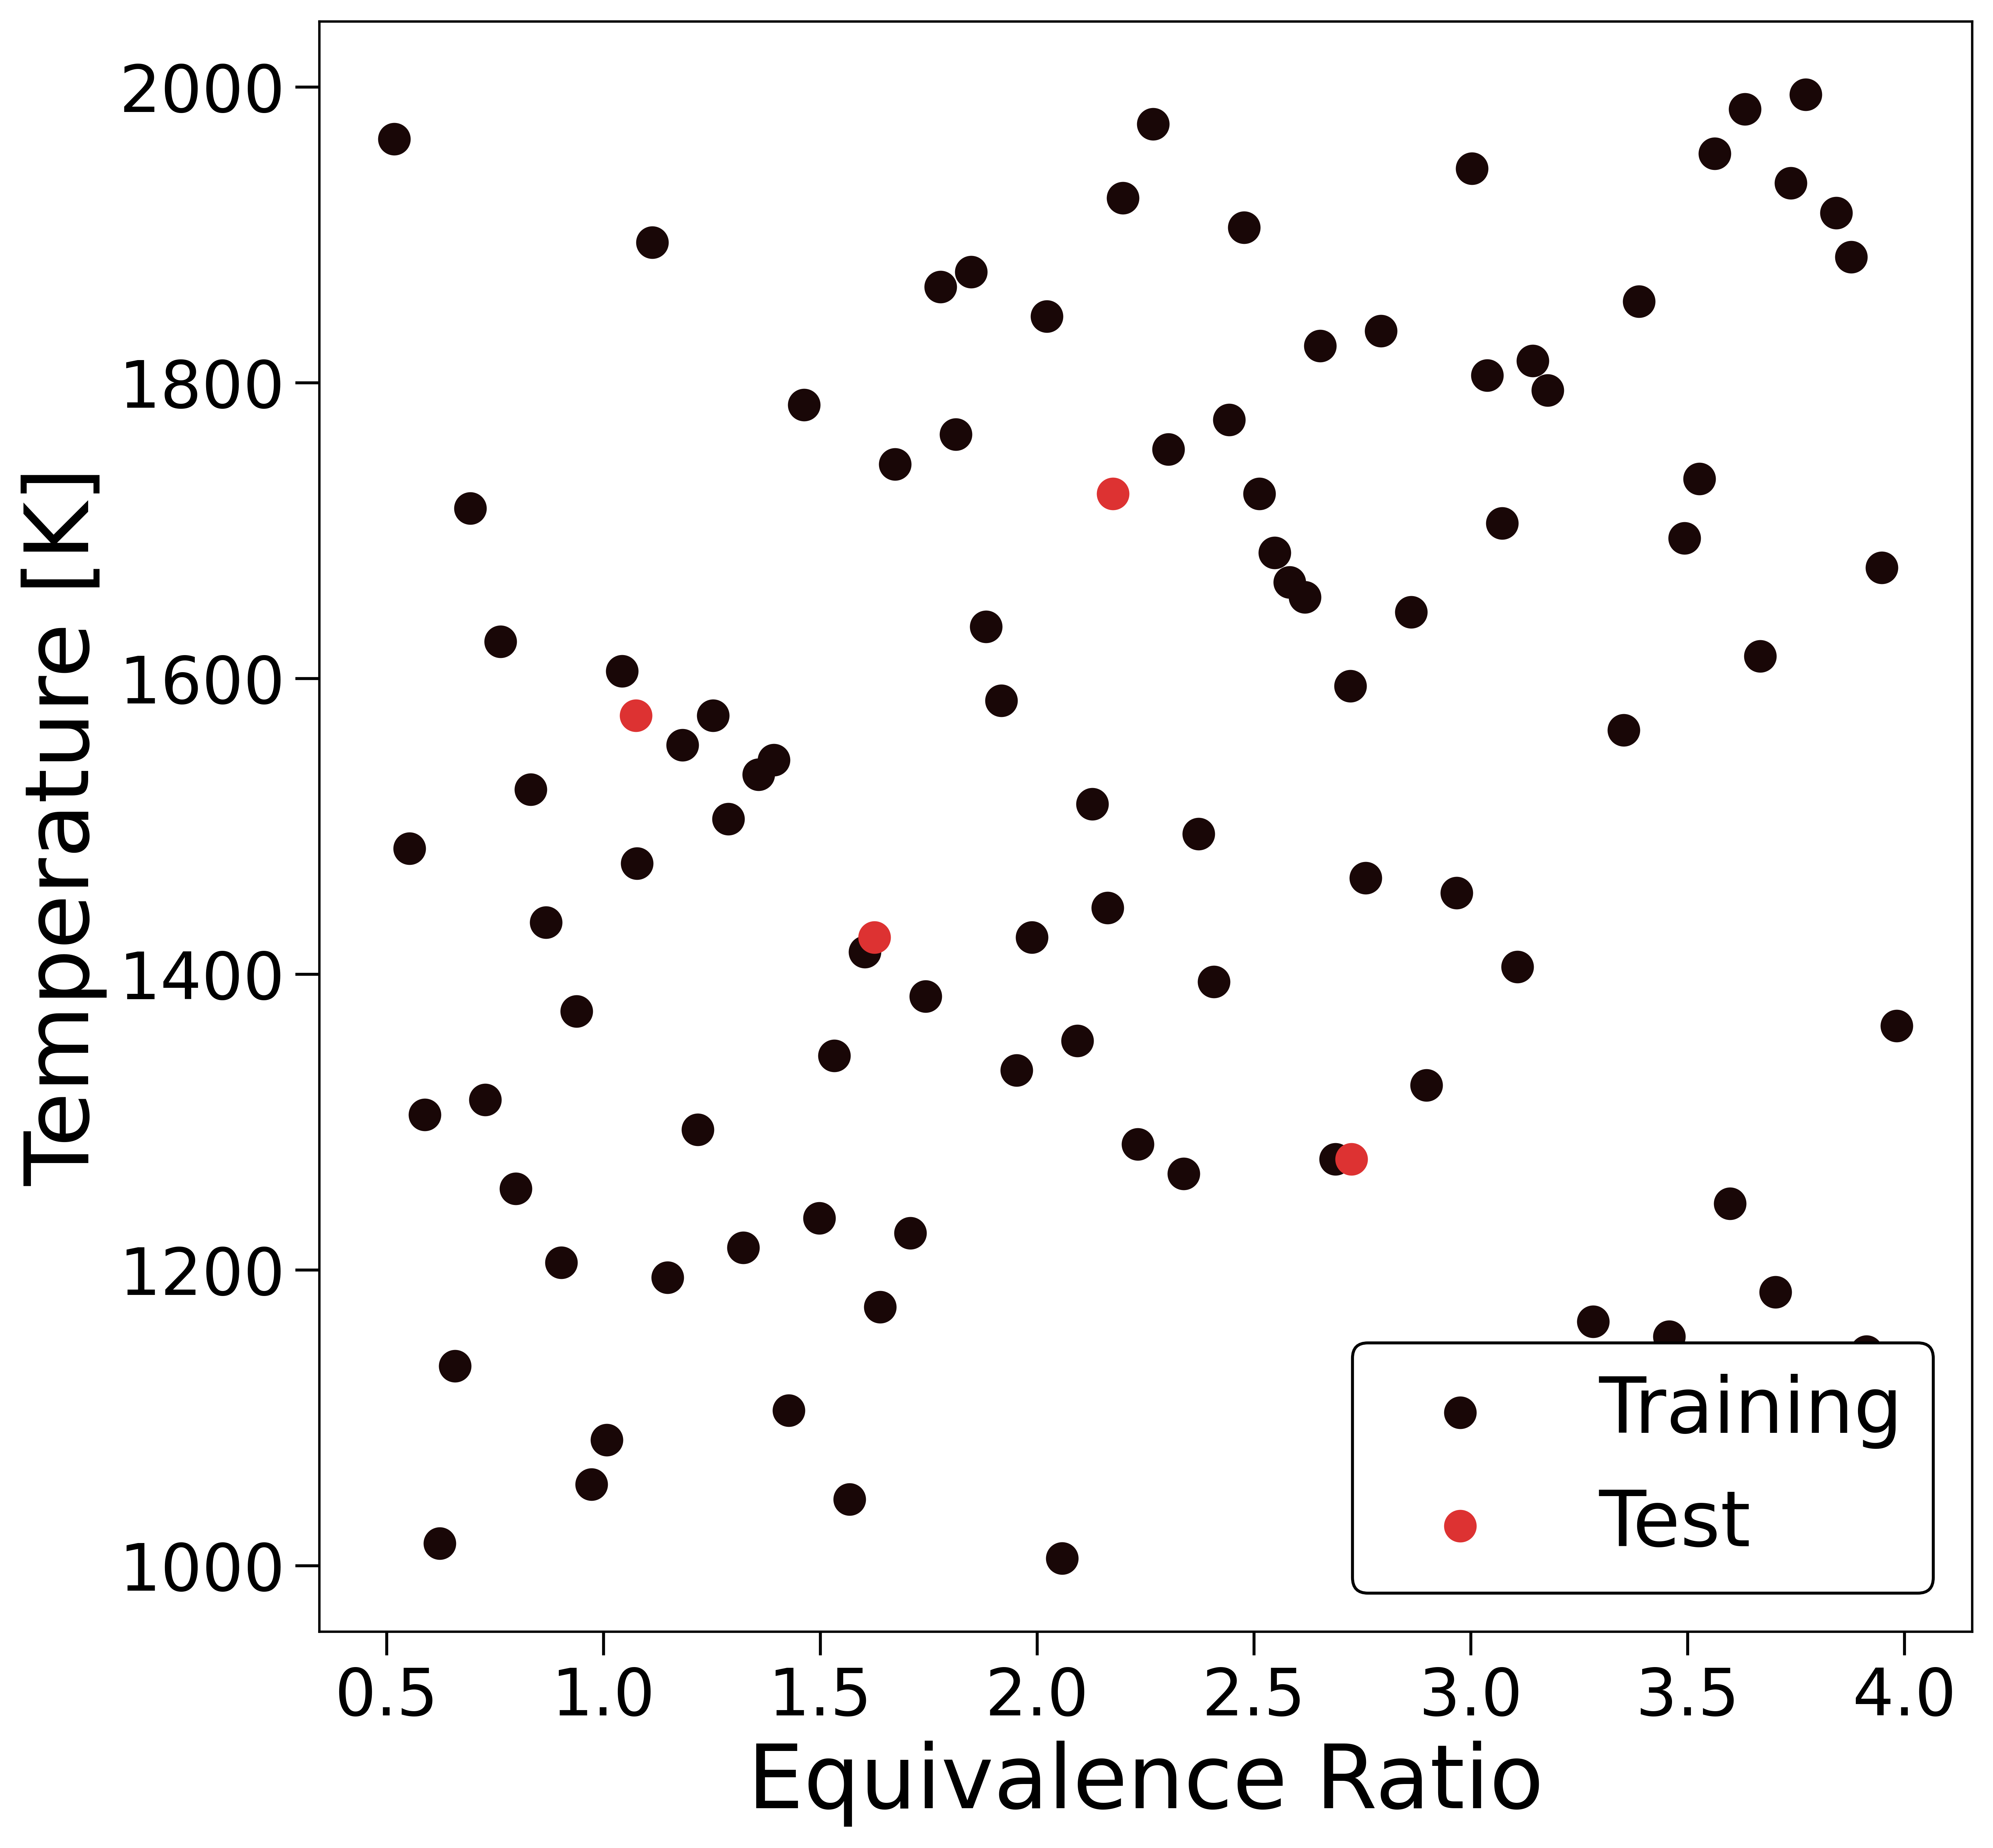

In [3]:
FileName = os.path.join(OutputDir, 'Orig/train/ext/CleanVars.csv')
Vars     = pd.read_csv(FileName, header=None)
Vars     = list(Vars.to_numpy()[0,:])
Vars0    = [Vars[i]+'0' for i in range(len(Vars))]
Var0Dic  = {}
for Var in Vars:
    Var0Dic[Var] = Var+'0'

    
# FileName     = os.path.join(OutputDir, 'Orig/train/ext/SimIdxs.csv')
# Data         = pd.read_csv(FileName, header=0)
# SimIdxs      = Data.to_numpy(int)

FileName     = os.path.join(OutputDir, 'Orig/train/ext/ICs.csv')
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
n_ics        = len(ICVecs)

P0Vec        = []
EqRatio0Vec  = []
T0Vec        = []
for iC in range(n_ics):
    P0Vec.append(       np.ones(1, dtype=np.float64)*ICVecs[iC,0])
    EqRatio0Vec.append( np.ones(1, dtype=np.float64)*ICVecs[iC,1])
    T0Vec.append(       np.ones(1, dtype=np.float64)*ICVecs[iC,2])
P0Vec        = np.concatenate(P0Vec)[...,np.newaxis]
EqRatio0Vec  = np.concatenate(EqRatio0Vec)[...,np.newaxis]
T0Vec        = np.concatenate(T0Vec)[...,np.newaxis]


# FileName     = os.path.join(OutputDir, 'Orig/test/ext/SimIdxs.csv')
# Data         = pd.read_csv(FileName, header=0)
# SimIdxsTest  = Data.to_numpy(int)

FileName     = os.path.join(OutputDir, 'Orig/test/ext/ICs.csv')
Data         = pd.read_csv(FileName)
ICVecsTest   = Data.to_numpy()
n_ics_test   = len(ICVecsTest)

P0VecTest       = []
EqRatio0VecTest = []
T0VecTest       = []
for iC in range(n_ics_test):
    P0VecTest.append(       np.ones(1, dtype=np.float64)*ICVecsTest[iC,0])
    EqRatio0VecTest.append( np.ones(1, dtype=np.float64)*ICVecsTest[iC,1])
    T0VecTest.append(       np.ones(1, dtype=np.float64)*ICVecsTest[iC,2])
P0VecTest        = np.concatenate(P0VecTest)[...,np.newaxis]
EqRatio0VecTest  = np.concatenate(EqRatio0VecTest)[...,np.newaxis]
T0VecTest        = np.concatenate(T0VecTest)[...,np.newaxis]


fig = plt.figure()
plt.scatter(EqRatio0Vec,     T0Vec,                    label='Training')
plt.scatter(EqRatio0VecTest, T0VecTest, c=ColorVec[1], label='Test')
plt.xlabel('Equivalence Ratio')
plt.ylabel('Temperature [K]')
plt.legend(loc=4)

if (FigDir):
    plt.savefig(FigDir+'/0DReact_ICs.eps', format='eps', bbox_inches='tight')

In [4]:
ParamsDF = pd.read_csv(ParamsDir+'/Perts.csv',header=None)
kNames   = ['k_'+str(i+1) for i in range(ParamsDF.shape[1])]

ParamsDF.columns = kNames
ParamsDF.head(5)

InputVar = ['t'] + Vars0 + kNames

In [5]:
from tqdm.notebook import tqdm

iFile = 0
Data  = []
for ics in tqdm(range(n_ics)):
    for iSample in range(n_samples):
        FileName         = OutputDir+'/Orig/train/ext/y.csv.'+str(iFile+1)
        DataNew          = pd.read_csv(FileName, header=0)
        Nts              = len(DataNew)

        # DataTemp         = DataNew.iloc[[0]][Vars] #DataTemp.iloc[1][Vars]
        # DataTemp         = DataTemp.loc[DataTemp.index.repeat(Nts)]
        # DataTemp.reset_index(drop=True, inplace=True)
        # DataNew[Vars0]   = DataTemp
        DataNew[Vars0]   = np.tile(DataNew.iloc[[0]][Vars].to_numpy(), (Nts,1))

        # ParamsTemp = ParamsDF.iloc[[iSample]]
        # ParamsTemp = ParamsTemp.loc[ParamsTemp.index.repeat(Nts)]
        # ParamsTemp.reset_index(drop=True, inplace=True)
        #DataNew[kNames]  = ParamsTemp
        DataNew[kNames]  = np.tile(ParamsDF.iloc[iSample].to_numpy(), (Nts,1))

        #DataTemp['t']    = DataNew['t']
        DataNew['t']     = np.maximum(DataNew['t'].to_numpy() - DataNew['t'].iloc[[0]].to_numpy(), FixedMinVal)
        Data.append(DataNew)
        iFile += 1
        
Data = pd.concat(Data, axis=0)
        
Data.reset_index(drop=True, inplace=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
Data

,t,T,H2,H,O,O2,OH,H2O,HO2,H2O2,...,HNO0,N20,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8
0,1.000000e-14,1705.000000,0.079188,0.000000e+00,0.000000e+00,0.204535,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.716277,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16
1,9.999999e-08,1704.998081,0.079188,2.008813e-08,8.175004e-09,0.204535,9.154066e-09,8.214546e-09,6.537527e-07,2.698380e-09,...,0.0,0.716277,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16
2,1.084810e-07,1704.997918,0.079188,2.184550e-08,9.358701e-09,0.204535,1.050782e-08,1.028529e-08,7.089413e-07,3.164091e-09,...,0.0,0.716277,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16
3,1.176812e-07,1704.997741,0.079188,2.376829e-08,1.069761e-08,0.204535,1.204395e-08,1.286189e-08,7.687653e-07,3.709071e-09,...,0.0,0.716277,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16
4,1.276617e-07,1704.997549,0.079188,2.587471e-08,1.220951e-08,0.204535,1.378396e-08,1.606314e-08,8.336103e-07,4.346513e-09,...,0.0,0.716277,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16,-1.110223e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,7.220809e-01,2633.890389,0.044318,1.641825e-03,1.707146e-04,0.000080,3.807669e-03,2.275544e-01,9.468709e-08,2.534017e-08,...,0.0,0.722139,-1.818182e-02,6.181818e-01,-5.818182e-01,1.090909e-01,-8.727273e-01,6.545455e-01,7.272727e-02,5.454545e-02
1999996,7.833203e-01,2633.890389,0.044318,1.641825e-03,1.707146e-04,0.000080,3.807669e-03,2.275544e-01,9.468709e-08,2.534017e-08,...,0.0,0.722139,-1.818182e-02,6.181818e-01,-5.818182e-01,1.090909e-01,-8.727273e-01,6.545455e-01,7.272727e-02,5.454545e-02
1999997,8.497534e-01,2633.890389,0.044318,1.641825e-03,1.707146e-04,0.000080,3.807669e-03,2.275544e-01,9.468709e-08,2.534017e-08,...,0.0,0.722139,-1.818182e-02,6.181818e-01,-5.818182e-01,1.090909e-01,-8.727273e-01,6.545455e-01,7.272727e-02,5.454545e-02
1999998,9.218207e-01,2633.890389,0.044318,1.641825e-03,1.707146e-04,0.000080,3.807669e-03,2.275544e-01,9.468709e-08,2.534017e-08,...,0.0,0.722139,-1.818182e-02,6.181818e-01,-5.818182e-01,1.090909e-01,-8.727273e-01,6.545455e-01,7.272727e-02,5.454545e-02


In [7]:
# ### Writing Input
# DataInput.to_csv(OutputDir+'/Orig/train/ext/Input.csv', index=False)
# tVec                = DataInput.t.to_numpy()

# ### Writing PCs
# DataOutput.to_csv(OutputDir+'/Orig/train/ext/Output.csv', index=False)

# Data_MinMax         = pd.concat([DataOutput[Vars].min(), DataOutput[Vars].max()], axis=1)
# Data_MinMax.columns = ['Min','Max']
# Data_MinMax.to_csv(OutputDir+'/Orig/train/ext/Output_MinMax.csv', index=False)

In [8]:
MinVal = []
MaxVal = []
for i in range(len(Vars)):
    MinVal.append(np.min([Data[Vars0[i]].min(), DataNew[Vars[i]].min()])*(0.9))
    MaxVal.append(np.max([Data[Vars0[i]].max(), DataNew[Vars[i]].max()])*(1.1))
MinVal = np.array(MinVal)
MaxVal = np.array(MaxVal)
DataDF = np.concatenate([MinVal[np.newaxis,...],MaxVal[np.newaxis,...]], axis=0)
DataDF = pd.DataFrame(DataDF, columns=Vars)
DataDF = DataDF.clip(lower=1.e-30)

ExtsFile = OutputDir+'/Orig/MinMax.csv'
DataDF.to_csv(ExtsFile, index=False)

## Splitting Data and Writing Database 

In [9]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/Orig/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/Orig/valid/')
except:
    pass

In [10]:
data_id    = 'pts'

DataNoZero           = Data[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/Orig/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/Orig/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[InputVar]
DataInput.iloc[train_idx].to_csv(OutputDir+'/Orig/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Input.csv', index=False)

DataOutput = DataNoZero[['t'] + Vars]
DataOutput.iloc[train_idx].to_csv(OutputDir+'/Orig/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Output.csv', index=False)

In [11]:
data_id    = 'res'

DataNoZero           = Data[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/Orig/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/Orig/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[InputVar]
DataInput.iloc[train_idx].to_csv(OutputDir+'/Orig/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Input.csv', index=False)

DataOutput       = DataNoZero[['t'] + Vars]
DataOutput[Vars] = DataOutput[Vars].to_numpy() * 0.
DataOutput.iloc[train_idx].to_csv(OutputDir+'/Orig/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Output.csv', index=False)

/var/folders/09/5pnsdvfx78nbjmwff3_24d540000gp/T/ipykernel_28301/3647220390.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataOutput[Vars] = DataOutput[Vars].to_numpy() * 0.


In [12]:
data_id = 'ics'

Data_ics                     = Data[Data['t'] == FixedMinVal]
n_points_ics                 = len(Data_ics)

idx_ics                      = np.arange(n_points_ics)
train_idx_ics, valid_idx_ics = train_test_split(idx_ics, test_size=valid_perc/100, random_state=41)

n_valid                      = len(valid_idx)
n_train                      = len(train_idx)

try:
    os.makedirs(OutputDir+'/Orig/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/Orig/valid/'+data_id+'/')
except:
    pass

DataInput  = Data_ics[InputVar]
DataInput.iloc[train_idx_ics].to_csv(OutputDir+'/Orig/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx_ics].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Input.csv', index=False)

DataOutput = Data_ics[['t'] + Vars]
DataOutput.iloc[train_idx_ics].to_csv(OutputDir+'/Orig/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx_ics].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Output.csv', index=False)

In [13]:
# data_id = 'scs'

# Mask                         = [i for i in range(1,len(Data)-1) if Data.iloc[i-51]['t'] == FixedMinVal]
# Data_ics                     = Data.iloc[Mask]
# n_points_ics                 = len(Data_ics)
# idx_ics                      = np.arange(n_points_ics)
# train_idx_ics, valid_idx_ics = train_test_split(idx_ics, test_size=valid_perc/100, random_state=41)

# try:
#     os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/')
# except:
#     pass
# try:
#     os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/')
# except:
#     pass

# DataInput      = Data_ics[InputVar]
# DataInput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Input.csv', index=False)
# DataInput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Input.csv', index=False)

# DataOutput     = Data_ics[['t'] + Vars]
# DataOutput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Output.csv', index=False)
# DataOutput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Output.csv', index=False)

In [14]:
# data_id = 'fcs'

# Mask                         = [i for i in range(-1,len(Data)-1) if Data.iloc[i+1]['t'] == FixedMinVal]
# Data_ics                     = Data.iloc[Mask]

# n_points_ics                 = len(Data_ics)
# idx_ics                      = np.arange(n_points_ics)
# train_idx_ics, valid_idx_ics = train_test_split(idx_ics, test_size=valid_perc/100, random_state=43)

# try:
#     os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/')
# except:
#     pass
# try:
#     os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/')
# except:
#     pass

# DataInput      = Data_ics[InputVar]
# DataInput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Input.csv', index=False)
# DataInput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Input.csv', index=False)

# DataOutput       = Data_ics[['t'] + Vars]
# DataOutput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Output.csv', index=False)
# DataOutput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Output.csv', index=False)